In [1]:
# /Users/jun/Library/Mobile Documents/iCloud~com~omz-software~Pythonista3/Documents
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
import pickle
f = open('test.serialize','rb')
[userAcceleration, magneticField, attitude, relativeAltitude, gpses] = pickle.load(f)
f.close

<function BufferedReader.close>

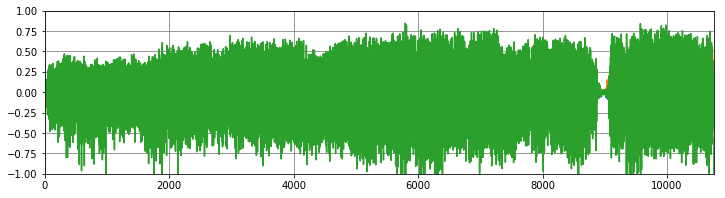

In [45]:
last=len(userAcceleration)
#last=500

userAccelerationX = np.array(userAcceleration)[:last,0]
userAccelerationY = np.array(userAcceleration)[:last,1]
userAccelerationZ = np.array(userAcceleration)[:last,2]
n = len(userAccelerationX)

timeStep = 1
x = timeStep*np.arange(0, n)

plt.figure(figsize=(12,3))
plt.ylim([-1,1])
plt.xlim([0,timeStep*n])
plt.grid(color='gray')
plt.plot(x, userAccelerationX)
plt.plot(x, userAccelerationY)
plt.plot(x, userAccelerationZ)


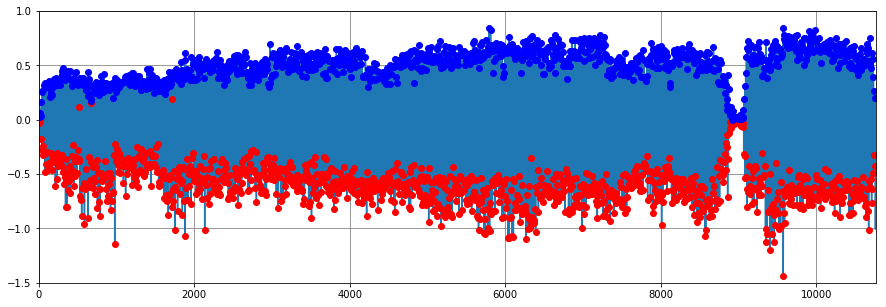

In [46]:
plt.figure(figsize=(15,5))
plt.ylim([-1.5,1])
plt.xlim([0,timeStep*n])
plt.grid(color='gray')

from peakdetect import peakdetect
bottoms = np.array(peakdetect(-userAccelerationZ, lookahead=3)[0])
tops = np.array(peakdetect(userAccelerationZ, lookahead=3)[0])

plt.plot(x, userAccelerationZ)
plt.plot(bottoms[:,0:1]*timeStep,-bottoms[:,1:2],'ro')
plt.plot(tops[:,0:1]*timeStep,tops[:,1:2],'bo')

Text(0,0.5,'Vertical (m)')

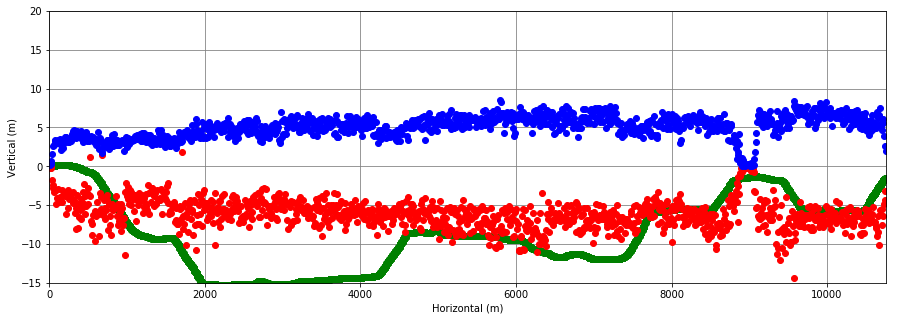

In [47]:
relativeAltitude = np.array(relativeAltitude)
plt.figure(figsize=(15,5))
plt.ylim([-15,20])
plt.xlim([0,n*timeStep])
plt.grid(color='gray')
plt.plot(x, relativeAltitude,"go")
'''
arrowStep=1
for i in range(1,n-arrowStep,arrowStep):
    plt.arrow(x[i],relativeAltitude[i],
              x[i+arrowStep]-x[i],relativeAltitude[i+arrowStep]-relativeAltitude[i], 
         color='b', lw=1, length_includes_head=True, shape='full', 
         head_length=2, head_width=0.2)
'''
plt.plot(bottoms[:,0:1]*timeStep,-bottoms[:,1:2]*10,'ro')
plt.plot(tops[:,0:1]*timeStep,tops[:,1:2]*10,'bo') 
    
plt.xlabel("Horizontal (m)")
plt.ylabel("Vertical (m)")

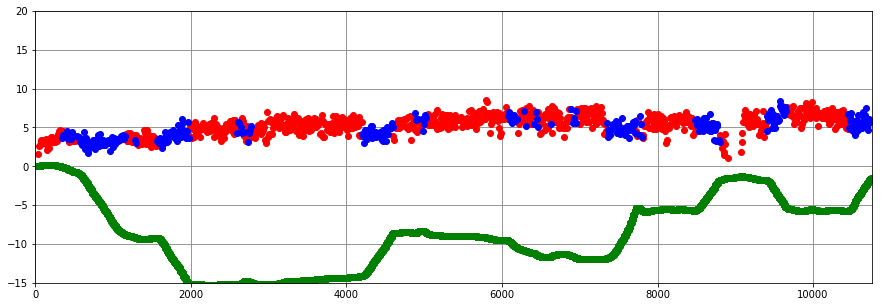

In [48]:
altDiffN = 30
insteps = []
inwalks = []

for top in tops:
    i = int(top[0:1]) # 元データのindex
    if i + altDiffN < len(relativeAltitude):
        if top[1:2] > 0.1: # 歩いていたら
            if abs(relativeAltitude[i+altDiffN]-relativeAltitude[i])>0.15: # 階段を上り下りしていたら
                insteps.append(top)
            else:
                inwalks.append(top)

insteps=np.array(insteps)
inwalks=np.array(inwalks)

plt.figure(figsize=(15,5))
plt.ylim([-15,20])
plt.xlim([0,n*timeStep])
plt.grid(color='gray')
plt.plot(x, relativeAltitude,"go")
plt.plot(inwalks[:,0:1]*timeStep,inwalks[:,1:2]*10,'ro') 
plt.plot(insteps[:,0:1]*timeStep,insteps[:,1:2]*10,'bo') 

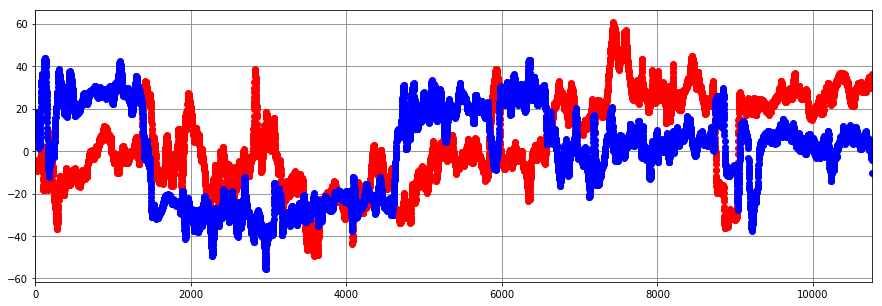

In [49]:
mX = np.array(magneticField)[:last,0]
mY = np.array(magneticField)[:last,1]
mZ = np.array(magneticField)[:last,2]


plt.figure(figsize=(15,5))
#plt.ylim([-15,20])
plt.xlim([0,n*timeStep])
plt.grid(color='gray')
plt.plot(x, mX,"ro")
plt.plot(x, mY,"bo")
#plt.plot(x, mZ,"go")

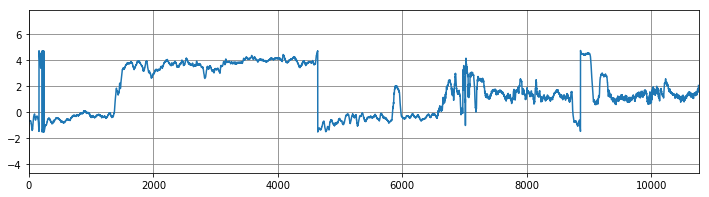

In [50]:
#https://nshipster.com/cmdevicemotion/
headingRad=pi/2.0-np.arctan2(mY,mX)
headingRad=pi/2.0-np.arctan2(mY,(mX+50)/(50+70)*100-50)

plt.figure(figsize=(12,3))
plt.ylim([pi/2.0-2*pi,pi/2.0+2*pi])
plt.xlim([0,n*timeStep])
plt.grid(color='gray')
plt.plot(x, headingRad)

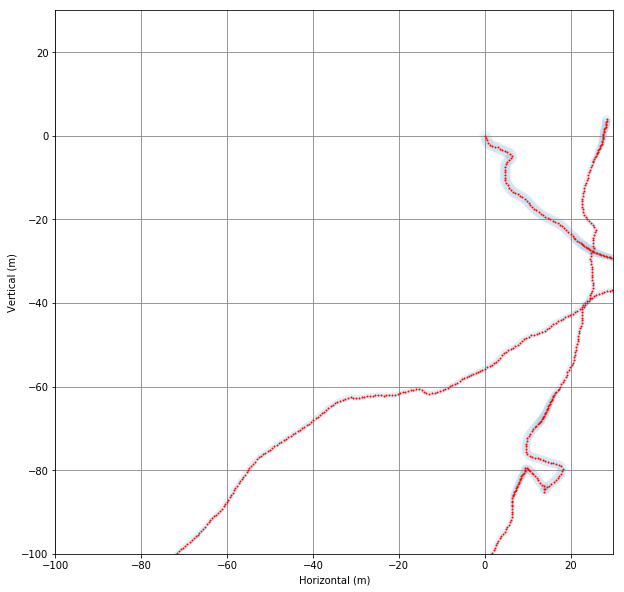

In [51]:
#plt.plot(tops[:,0:1]*timeStep,tops[:,1:2]*10,'bo') 

xy = np.array([0.0,0.0])
xys = np.empty((0,2), float)
#xys = np.append(xys, np.array([xy]), axis=0)
xys = np.append(xys, [xy], axis=0)

zs = np.empty((0,1), float)
zs = np.append(zs, np.array([0.0]))

xyzs = np.empty((0,3), float)
xyzs = np.append(xyzs, [np.array([0,0,0])], axis=0)

for top in tops:
    i = int(top[0:1]) # 元データのindex
    if i + altDiffN < len(relativeAltitude):
        if top[1:2] > 0.15: # 歩いていたら
            if abs(relativeAltitude[i+altDiffN]-relativeAltitude[i])>0.2: # 階段を上り下りしていたら
                footstep = 0.35
            else:
                footstep = 0.65
            xy = xy + np.array(footstep)*[math.cos(headingRad[i]),math.sin(headingRad[i])] 
            xys = np.append(xys, [xy], axis=0)
            zs = np.append(zs, [relativeAltitude[i]])
            #print([xy[0],xy[1],relativeAltitude[i]])
            xyzs = np.append(xyzs,[np.array([xy[0],xy[1],relativeAltitude[i]])], axis=0)
            
plt.figure(figsize=(10,10))
plt.grid(color='gray')

plt.ylim([-100,30])
plt.xlim([-100,30])

plt.scatter(x = xys[:,0],y = xys[:,1], s=(zs+10)*(zs+10), alpha = 0.05)
plt.plot(xys[:,0], xys[:,1],'ro',markersize=1)


plt.xlabel("Horizontal (m)")
plt.ylabel("Vertical (m)")

plt.figure(figsize=(12,3))

In [37]:
# pip install  --upgrade pip
# pip install git+https://github.com/daavoo/pyntcloud

import numpy as np
import pandas as pd
from pyntcloud import PyntCloud

points = pd.DataFrame( xyzs.astype(np.float32),
                      columns=['x', 'y', 'z'])
points -= points.mean(0)

n = len(points)
timeseries = []
for i in range(n):
    timeseries.append(255.0*i/n)

points["red"] = ((xyzs[:,2]+10)*10).astype(np.uint8)
#points["green"] = np.full(len(points), 0, dtype=np.uint8)
points["green"] = (255-(xyzs[:,2]+10)*10).astype(np.uint8)
points["blue"] = np.array(timeseries).astype(np.uint8)

cloud = PyntCloud(points)
cloud.to_file("output5.ply")
cloud.plot(initial_point_size=0.5)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(1.499729751230916e-05, 45.83377613559878, 14…